In [1]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append("..")

import os
os.environ['R_HOME'] = 'D:/Program Files/R-4.5.0' #@TODO include in some setup file

from simulation_engine.scenarios.iv.binary_iv import BinaryIV
from simulation_engine.scenarios.iv.continuous_iv import ContinuousIV
from simulation_engine.util.plotting_util import PlottingUtil

import pandas as pd
pd.set_option('display.max_columns', None)

#disable warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import matplotlib.pyplot as plt
import seaborn as sns
import math
# from linearmodels.iv import IV2SLS
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.neural_network import MLPClassifier
# Train a decision tree classifier to predict 'tightest_bounds'
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from simulation_engine.util.plotting_util import PlottingUtil
pd.options.mode.chained_assignment = None  # default='warn'


In [3]:
import re

#setup
# results = pd.read_pickle('testrun.pkl')
results = pd.read_pickle('../simulation_engine/results/contIV/06_06/results.pkl')
binaryIV = ContinuousIV('IV DAG', results)
ATE_algs = binaryIV.get_algorithms('ATE')
PNS_algs = binaryIV.get_algorithms('PNS')
algs = ATE_algs + PNS_algs
results


,seed,b_Z_X,b_U_X,b_X_Y,b_U_Y,p_Z,sigma_X,sigma_Y,sigma_U,g_U_X,g_U_Y,squash_X,squash_Y,g_Y,ATE_true,PNS_true,p_Y1_mean,p_Y0_mean,Z,U,X,Y,Y_max,Y_min,X_max,X_min,X_mean,Y_mean,entropy_Z,entropy_X,ATE_zhangbareinboim_bound_lower,ATE_zhangbareinboim_bound_upper,ATE_zhangbareinboim_bound_valid,ATE_zhangbareinboim_bound_width,ATE_zhangbareinboim_bound_failed,ATE_causaloptim--binned_bound_lower,ATE_causaloptim--binned_bound_upper,ATE_causaloptim--binned_bound_valid,ATE_causaloptim--binned_bound_width,ATE_causaloptim--binned_bound_failed,ATE_autobound--binned_bound_lower,ATE_autobound--binned_bound_upper,ATE_autobound--binned_bound_valid,ATE_autobound--binned_bound_width,ATE_autobound--binned_bound_failed,ATE_zaffalonbounds--binned_bound_lower,ATE_zaffalonbounds--binned_bound_upper,ATE_zaffalonbounds--binned_bound_valid,ATE_zaffalonbounds--binned_bound_width,ATE_zaffalonbounds--binned_bound_failed,ATE_2SLS-0.99_bound_lower,ATE_2SLS-0.99_bound_upper,ATE_2SLS-0.99_bound_valid,ATE_2SLS-0.99_bound_width,ATE_2SLS-0.99_bound_failed,ATE_2SLS-0.98_bound_lower,ATE_2SLS-0.98_bound_upper,ATE_2SLS-0.98_bound_valid,ATE_2SLS-0.98_bound_width,ATE_2SLS-0.98_bound_failed,ATE_2SLS-0.95_bound_lower,ATE_2SLS-0.95_bound_upper,ATE_2SLS-0.95_bound_valid,ATE_2SLS-0.95_bound_width,ATE_2SLS-0.95_bound_failed,ATE_entropybounds-0.80--binned_bound_lower,ATE_entropybounds-0.80--binned_bound_upper,ATE_entropybounds-0.80--binned_bound_valid,ATE_entropybounds-0.80--binned_bound_width,ATE_entropybounds-0.80--binned_bound_failed,ATE_entropybounds-0.20--binned_bound_lower,ATE_entropybounds-0.20--binned_bound_upper,ATE_entropybounds-0.20--binned_bound_valid,ATE_entropybounds-0.20--binned_bound_width,ATE_entropybounds-0.20--binned_bound_failed,ATE_entropybounds-0.10--binned_bound_lower,ATE_entropybounds-0.10--binned_bound_upper,ATE_entropybounds-0.10--binned_bound_valid,ATE_entropybounds-0.10--binned_bound_width,ATE_entropybounds-0.10--binned_bound_failed
0,918531,1.731940,0.089485,-10.000000,-0.037210,0.882975,0.828296,0.334479,0.001408,exp_neg_sq,rescaled_identity,tanh_scaled,probit,zero_centered_tanh,-3.362544e-01,0.000,1.586553e-01,0.494910,"[1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[-0.0026023233621933805, -0.000275808585568048...","[0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[0.48980486786595684, 0.30715458518052985, 0.1...",0.777931,1.586553e-01,1,0,0.894,0.192600,0.475304,0.487732,-0.608783,0.007052,True,0.615835,False,-0.517796,-0.346303,False,0.171492,False,-0.725490,-0.109655,True,0.615835,False,-0.6882,-0.2927,True,0.3955,False,-0.377218,-0.215992,True,0.161226,False,-0.369410,-0.223799,True,0.145611,False,-0.357944,-0.235266,True,0.122678,False,-0.947001,0.053001,True,1.000002,False,-0.947000,0.001703,True,0.948703,False,-0.902661,-0.068205,True,0.834456,False
1,320152,1.066532,-1.426908,-9.989995,-0.659637,0.521275,0.179229,0.854530,0.123389,sigmoid,sine_sym,probit,tanh_scaled,identity,-4.822139e-01,0.000,7.681313e-09,0.482214,"[1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, ...","[-0.10173781524751706, -0.04565892035052234, 0...","[0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, ...","[0.9448090104424047, 4.209890214212919e-10, 0....",0.994623,1.698952e-11,1,0,0.422,0.272613,0.999896,0.982373,-0.606533,0.023541,True,0.630075,False,-0.601735,-0.148581,True,0.453153,False,-0.603239,0.026836,True,0.630075,False,-0.4950,-0.1376,True,0.3574,False,-0.670769,-0.388115,True,0.282653,False,-0.657081,-0.401803,True,0.255277,False,-0.636978,-0.421906,True,0.215073,False,-0.710996,0.252897,True,0.963893,False,-0.691664,-0.093824,True,0.597840,False,-0.647233,-0.236392,True,0.410841,False
2,945122,-1.112324,1.163090,-9.979990,-0.084199,0.535730,0.129668,0.536787,0.628399,exp_clipped,zero_centered_tanh,sigmoid,tanh_scaled,cos,-6.627140e-01,0.004,1.865689e-01,0.849283,"[1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, ...","[0.22378106571511275, -0.39097552375525624, 0....","[0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, ...","[0.8500122581205967, 0.845615778306

                     Algorithm Fail Rate (%) Invalid Rate (%) Net Bound Width Bound Width
                 ATE_2SLS-0.95          0.40             7.63          0.4576      0.5810
                 ATE_2SLS-0.98          0.40             6.83          0.5102      0.6175
                 ATE_2SLS-0.99          0.40             6.17          0.5424      0.6379
ATE_entropybounds-0.10--binned          0.00            43.40          0.5657      1.1882
    ATE_zaffalonbounds--binned          0.00            18.35          0.5994      0.8564
       ATE_causaloptim--binned          8.05            18.92          0.7060      1.0353
ATE_entropybounds-0.20--binned          0.00            20.60          0.7229      0.9860
         ATE_autobound--binned         30.15             6.66          0.7889      1.2104
           ATE_zhangbareinboim          0.00             0.40          0.7895      0.7944
ATE_entropybounds-0.80--binned          0.00             4.00          0.9833      1.0240


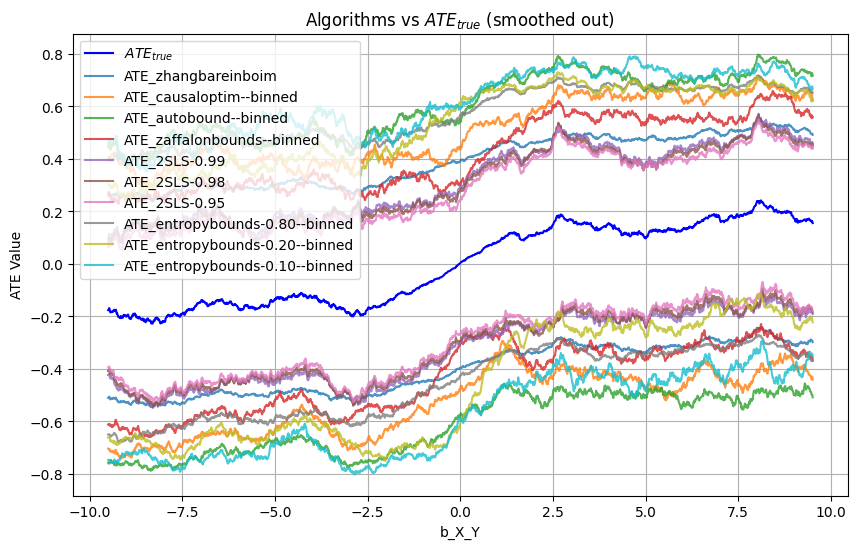

In [6]:
#ATE Evaluation
PlottingUtil.print_bound_statistics_table(results, algs, 'ATE')
PlottingUtil.plot_smoothed_query_vs_bounds(results, 'ATE', ATE_algs, 100)

             Algorithm Fail Rate (%) Invalid Rate (%) Net Bound Width Bound Width
           PNS_nonpara          0.00            27.55          0.1915      0.4142
    PNS_zaffalonbounds          0.00             1.50          0.3918      0.4009
       PNS_causaloptim          4.50            11.47          0.4106      0.5017
         PNS_autobound          1.20             1.47          0.4279      0.4431
PNS_entropybounds-0.10          0.00             0.25          0.5024      0.5036
PNS_entropybounds-0.20          0.00             0.10          0.5771      0.5775
PNS_entropybounds-0.80          0.00             0.10          0.7126      0.7129


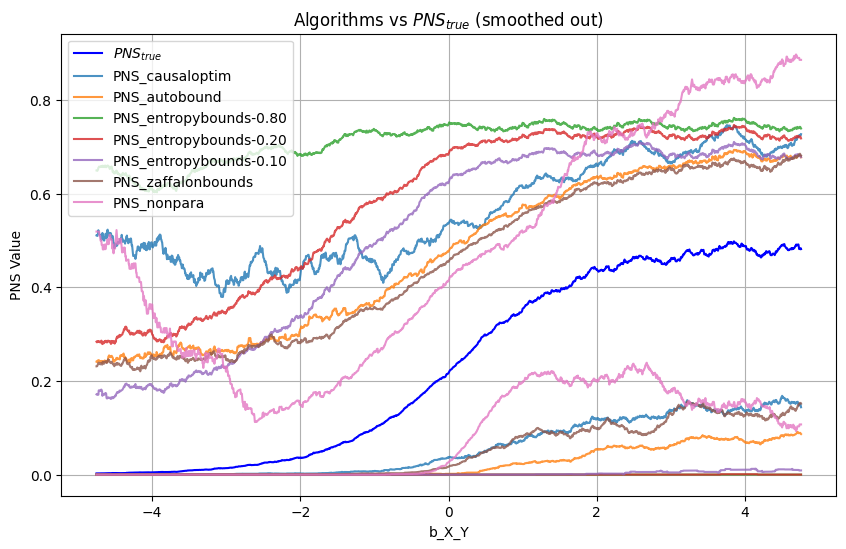

In [5]:
#PNS Evaluation
PlottingUtil.print_bound_statistics_table(results, algs, 'PNS')
PlottingUtil.plot_smoothed_query_vs_bounds(results, 'PNS', PNS_algs, 100)

ATE algorithms: ['2SLS-0.99', '2SLS-0.98', 'causaloptim', 'autobound', 'entropybounds-0.80', 'entropybounds-0.20', 'entropybounds-0.10', 'zaffalonbounds', 'nonpara']
PNS algorithms: ['causaloptim', 'autobound', 'entropybounds-0.80', 'entropybounds-0.20', 'entropybounds-0.10', 'zaffalonbounds', 'nonpara']
PNS algorithms: ['causaloptim', 'autobound', 'entropybounds-0.80', 'entropybounds-0.20', 'entropybounds-0.10', 'zaffalonbounds', 'nonpara']


d:\TUM Workspace\Thesis Workspace\causal-bounds\binaryIV\..\simulation_engine\util\plotting_util.py:233: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(counts.index, rotation=45, ha='right')


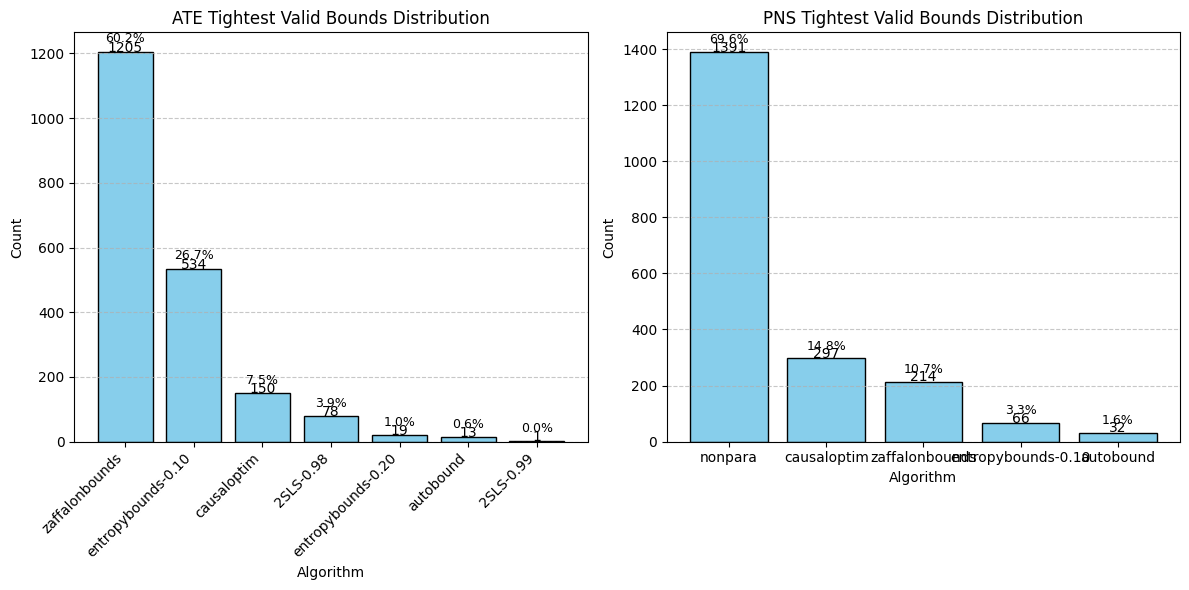

In [38]:
df = results.copy()
# Find tightest bounds without requiring bounds to be valid
tb = PlottingUtil.compute_tightest_bound_valid(df)
PlottingUtil.plot_tightest_bounds_distribution(tb, 'true')
